In [1]:
# Before starting import everything necessary
import setGPU

import h5py
import numpy as np
import os
import simplejson as json
import sys
import torch
import yaml

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from ssd.generator import CalorimeterJetDataset
from ssd.net import build_ssd
from utils import get_data_loader

setGPU: Setting GPU to: 0


In [2]:
# Set presentation settings
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

with open('../plots/palette.json') as json_file:
    color_palette = json.load(json_file)
plt.style.use('../plots/ssdjet.mplstyle')

In [3]:
CONFIG_FILE = '../ssd-config.yml'
MODEL = '../models/pfssd-tp.pth'
THRESHOLD = 0.2

config = yaml.safe_load(open(CONFIG_FILE))
ssd_settings = config['ssd_settings']
ssd_settings['n_classes'] += 1

In [4]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
net = build_ssd(0, config['ssd_settings'], inference=True)
net.load_weights(MODEL)
net.eval()

SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=32)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=32)
    (6): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): PReLU(num_parameters=64)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): PReLU(num_parameters=64)
    (13): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (14): Conv2d(64, 

In [5]:
# Plotting calorimeter energy deposit image in color
def calorimeter_image(labels, baselines, data2d, titles=[]):
    offset = 15
    fig = plt.figure(figsize=(14.0, 6.0))
    for i, (label, title, c) in enumerate(zip([labels, baselines], titles, ['red', 'teal'])):
        ax = plt.subplot(1, 2, i+1)
        ax.set_title(title, loc='right')
        ax.set_xlim([-offset, data2d.shape[1]+offset])
        ax.set_xlabel('$\eta$', horizontalalignment='right', x=1.0)
        ax.set_ylim([-offset, data2d.shape[0]+offset])
        ax.set_ylabel('$\phi [\degree$]', horizontalalignment='right', y=1.0)
        ax.imshow(data2d)

        for l in label:
            jet = patches.Rectangle((l[0]*340, l[1]*360),
                                    (l[2]-l[0])*340,
                                    (l[3]-l[1])*360,
                                    linewidth=2,
                                    edgecolor=color_palette[c]['shade_600'],
                                    facecolor='none')
            ax.add_patch(jet)
            ax.text(l[0]*340, l[3]*360,
                    config['evaluation_pref']['names_classes'][int(l[-2])-1],
                    weight='bold',
                    color=color_palette['grey']['shade_100'],
                    bbox={'facecolor': color_palette[c]['shade_900'], 'alpha': 1.0})
    plt.show();

In [6]:
loader = get_data_loader(config['dataset']['test'][0],
                         1,
                         0,
                         ssd_settings['input_dimensions'],
                         ssd_settings['object_size'],
                         return_pt=True,
                         shuffle=True)

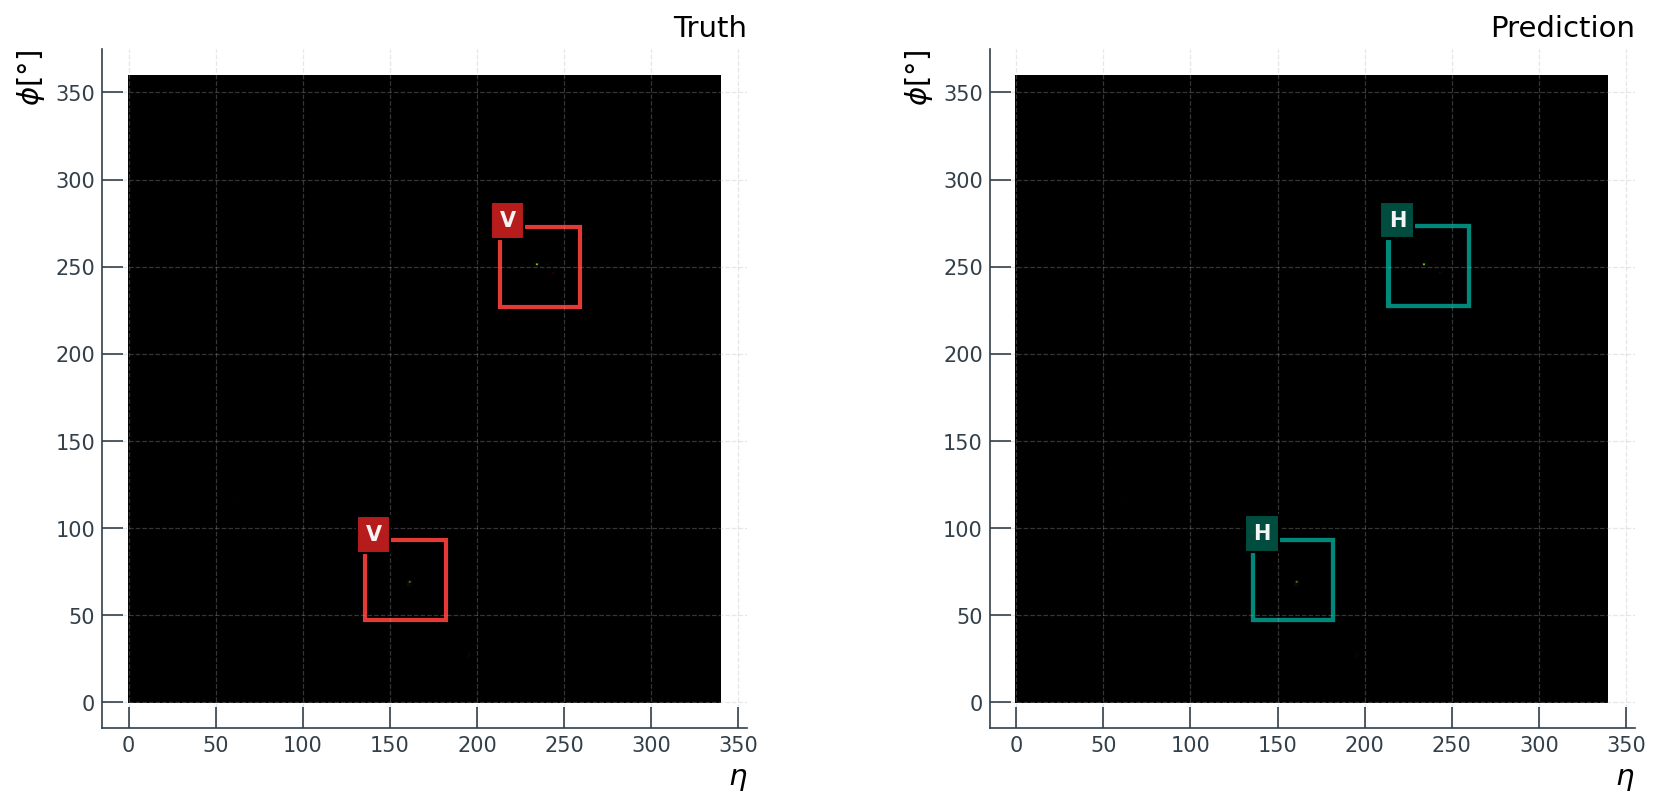

In [7]:
for image, target in loader:
    with torch.no_grad():
        detections = net(image).data.cpu().numpy()
        predictions = np.empty((0, 6))

        for cl, det in enumerate(detections[0]):
            columns = det.shape[1]
            mask = det[:, 0] >= THRESHOLD
            det = det.flatten()[np.repeat(mask, columns)]
            if len(det):
                det = det.reshape(-1, columns)
                cls = np.transpose(np.expand_dims(np.repeat(cl-1, det.shape[0]), 0))
                det = np.hstack((det[:, 1:5], cls+1, det[:, [0]]))
                predictions = np.vstack([predictions, det])
    
    calorimeter_image(
        np.array(target[0].cpu().numpy()),
        predictions,
        np.transpose(image[0].cpu().numpy(), (2,1,0)),
        ['Truth', 'Prediction']
    )
    
    break